In [1]:
## Add path to sys
import sys
sys.path.append('../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


## Image cropping example
https://www.kaggle.com/code/fadhlalhafizh/brain-tumor-vgg16-resnet50-inceptionv3

In [3]:
# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

### Trying TL Models

In [4]:
from keras.applications.resnet import ResNet50, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [8]:
def preprocess_for_resnet(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [9]:
X_train_prep = preprocess_for_resnet(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_resnet(set_name=X_test_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


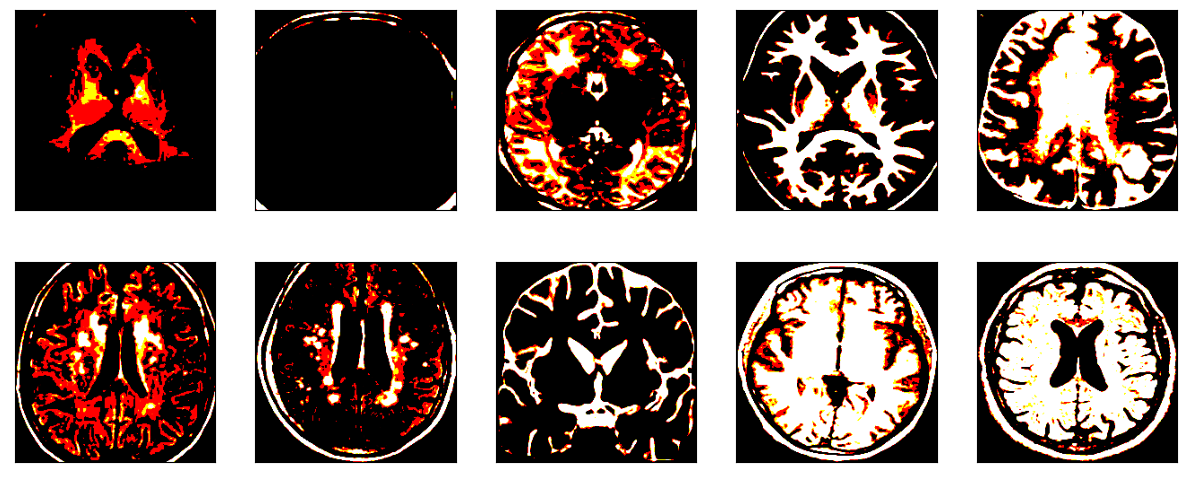

In [10]:
## Plot 10 images from X_train_crop
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_prep[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [19]:
## Make a VGG16 model and freeze the layers and add a head 
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False
model = Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


## Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 51,381,249
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
model.fit(
    X_train_prep,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.4,
    callbacks=[early_stopping]
)

Epoch 1/50
4/4 [==============================] - 21s 4s/step - loss: 35.5442 - accuracy: 0.6198 - val_loss: 57.0299 - val_accuracy: 0.3827
Epoch 2/50
4/4 [==============================] - 13s 4s/step - loss: 17.6129 - accuracy: 0.7934 - val_loss: 66.6133 - val_accuracy: 0.4444
Epoch 3/50
4/4 [==============================] - 13s 4s/step - loss: 4.1492 - accuracy: 0.9339 - val_loss: 14.7591 - val_accuracy: 0.8765
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 2.6717 - accuracy: 0.9504 - val_loss: 16.2370 - val_accuracy: 0.8395
Epoch 5/50
4/4 [==============================] - 13s 4s/step - loss: 1.2007e-15 - accuracy: 1.0000 - val_loss: 19.5643 - val_accuracy: 0.7654
Epoch 6/50
4/4 [==============================] - 13s 4s/step - loss: 0.0552 - accuracy: 0.9917 - val_loss: 20.6004 - val_accuracy: 0.7654
Epoch 7/50
4/4 [==============================] - 13s 4s/step - loss: 2.8984e-15 - accuracy: 1.0000 - val_loss: 19.8348 - val_accuracy: 0.7654
Epoch 8/50
4/4 [=

In [21]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 3s 1s/step - loss: 9.6621 - accuracy: 0.9216


[9.66205883026123, 0.9215686321258545]

## Checking the model

In [22]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 4s 994ms/step


array([[19,  1],
       [ 3, 28]], dtype=int64)

In [23]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


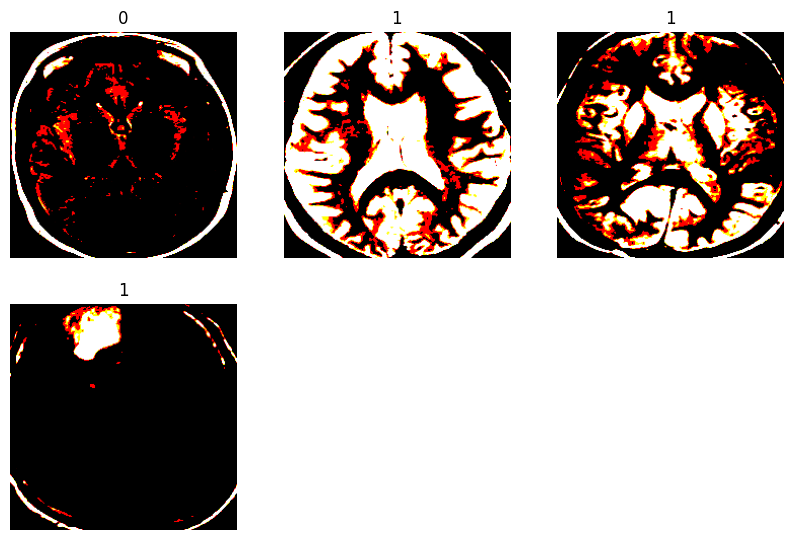

In [24]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

In [63]:
# ## Use lime explainer to explain the wrong prediction
# import lime
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

# explainer = lime_image.LimeImageExplainer()

# def predict_fn(images):
#     return model.predict(images)

# image_array = X_test_right[-6]

# explanation = explainer.explain_instance(
#     image_array,
#     classifier_fn=predict_fn,
#     top_labels=2,
#     hide_color=0,
#     num_samples=100)

# temp, mask = explanation.get_image_and_mask(
#     explanation.top_labels[0],
#     positive_only=True,
#     num_features=5,
#     hide_rest=True
# )

# lime_image = mark_boundaries(image_array, mask)

# # Plot the original image and Lime explanation overlay
# plt.imshow(lime_image)
# plt.title('Lime Explanation' + f" -- Top prediction: {explanation.top_labels[0]}")
# plt.axis('off')
# plt.show()


In [66]:
import shap
explainer = shap.DeepExplainer(model, data=X_test_prep)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [67]:
## Using SHAP to explain the model
import shap
# Create an explainer object
for i in range(len(X_test_wrong)):
    # Get a sample the wrong prediction
    sample = X_test_wrong[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_wrong[i]))
    plt.show()

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "c:\Users\GP65\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_AddV2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


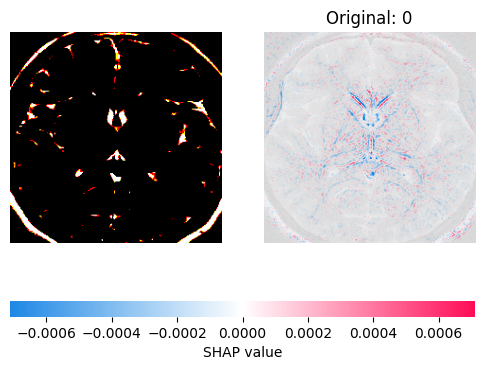

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


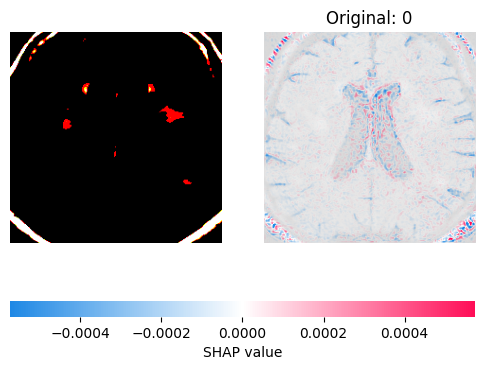

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


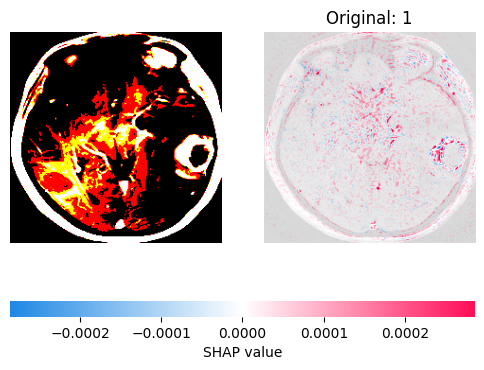

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


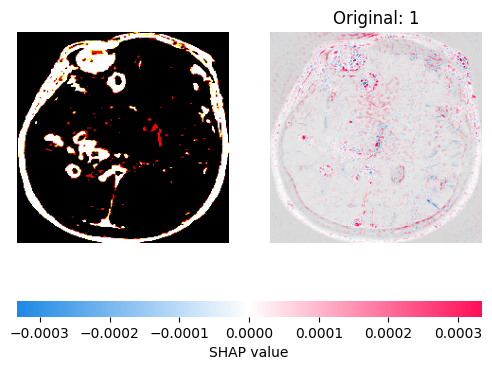

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


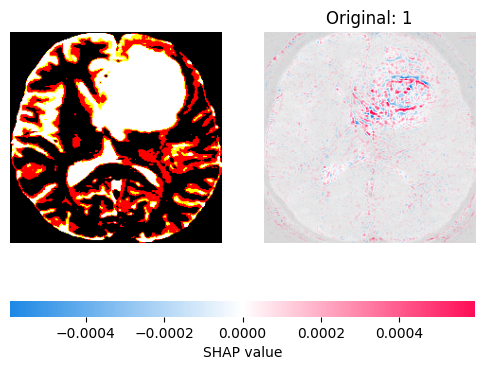

In [85]:
import shap
# Create an explainer object
for i in [0,5,-4,-5,-7]:
    # Get a sample the wrong prediction
    sample = X_test_right[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_right[i]))
    plt.show()
